# <center>[😺🚀 Его бустейшество - **`CatBoost`**!](https://stepik.org/lesson/779917/)</center>

### Оглавление ноутбука

<img src='https://mljar.com/images/machine-learning/catboost.png' align="right" width="750" height="750" />
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">🛠 Catboost Classifier и его параметры </a></li>

<li><a href="#c2">📂 Настраиваем обучение по фолдам :</a></li>
<li><a href="#look1">🔧 Best practices по настройке Catboost </a>
<li><a href="#check1"> 🔋 "Батарейки в комплекте!"</a>
<li><a href="#check1">🤷‍ Другие параметры и режимы</a>

<li><a href="#6">🧸 Выводы и заключения</a>

</li></ul></font></p>



<div class="alert alert-info">
    

**`CatBoost`** — это open-source библиотека градиентного бустинга на решающих деревьях с поддержкой категориальных фичей из коробки, преемник алгоритма `MatrixNet`, разработанного Яндексом.<br>
В плане простоты использования и легкости входа для новичков, пожалуй, является топ-1 библиотекой для табличных данных и вот почему:
* **Принимает категориальные фичи** сразу без всякой предварительной обработки.
* Чтобы перенести обучение с **`CPU`** на **`GPU`** достаточно поменять значение 1 параметра, без установки доп.пакетов или специальных версий, как в других библиотеках
* Даже с дефолтными параметрами выдает хорошую точность модели
  * Основные параметры не константные, а **подбираются самой библиотекой**, в зависимости от размера входных данных.
* Может принимать текстовые признаки, эмбеддинги, временные признаки.
* Без дополнительных манипуляций и оберток встраивается в стандартные пайплайны (например, `sklearn`).
* Идет в комплекте с "батарейками": `feature_selection`, `object_selection`, `cross_validation`, `grid_search` и пр.

<div class="alert alert-info">

**Из минусов: (почти нет)**
* Не умеет обрабатывать пропуски в данных (Сами избавляемся или заполняем `NaN` перед подачей в модель).
* Не все метрики и лоссы доступны при обучении на **`GPU`**.
* Не умеет делать кофе 

<div class="alert alert-info">

**В общем и целом, рекомендуем начинать всегда именно с этой библиотеки, особенно, если только начинаете вкатываться в соревнования.<br>
Алгоритм примерно следующий:**

1. Скачали данные
2. Провели быстрый EDA
3. Собрали список кат-фичей, закинули данные в **`CatBoost`**
4. Посмотрели, что модель дает с дефолтными фичами и параметрами. (baseline)
5. Отправили сабмишен на лидерборд.
6. Начинаем настройку валидации, **feature engeneering**, **тюнинг модели**, прочие манипуляции и танцы с бубном.

In [1]:
!pip install seaborn catboost -q

import numpy as np
import pandas as pd

# <center> Импортируем `train` датасет

train (2337, 17)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
611,L-2146603e,Smart ForTwo,economy,petrol,4.76,2014,60852,2022,55.92,engine_overheat,4.214138,1.394655e+07,0.1,179.128822,-3.120805,174,174
350,v-9234388J,VW Polo VI,economy,petrol,4.86,2014,54274,2015,53.30,another_bug,4.766494,1.503168e+07,0.1,178.000000,10.487676,174,171
1299,O-9483543e,Smart ForFour,economy,petrol,6.46,2014,66105,2020,32.25,engine_fuel,4.179425,1.202353e+07,0.1,169.646526,5.313803,174,169


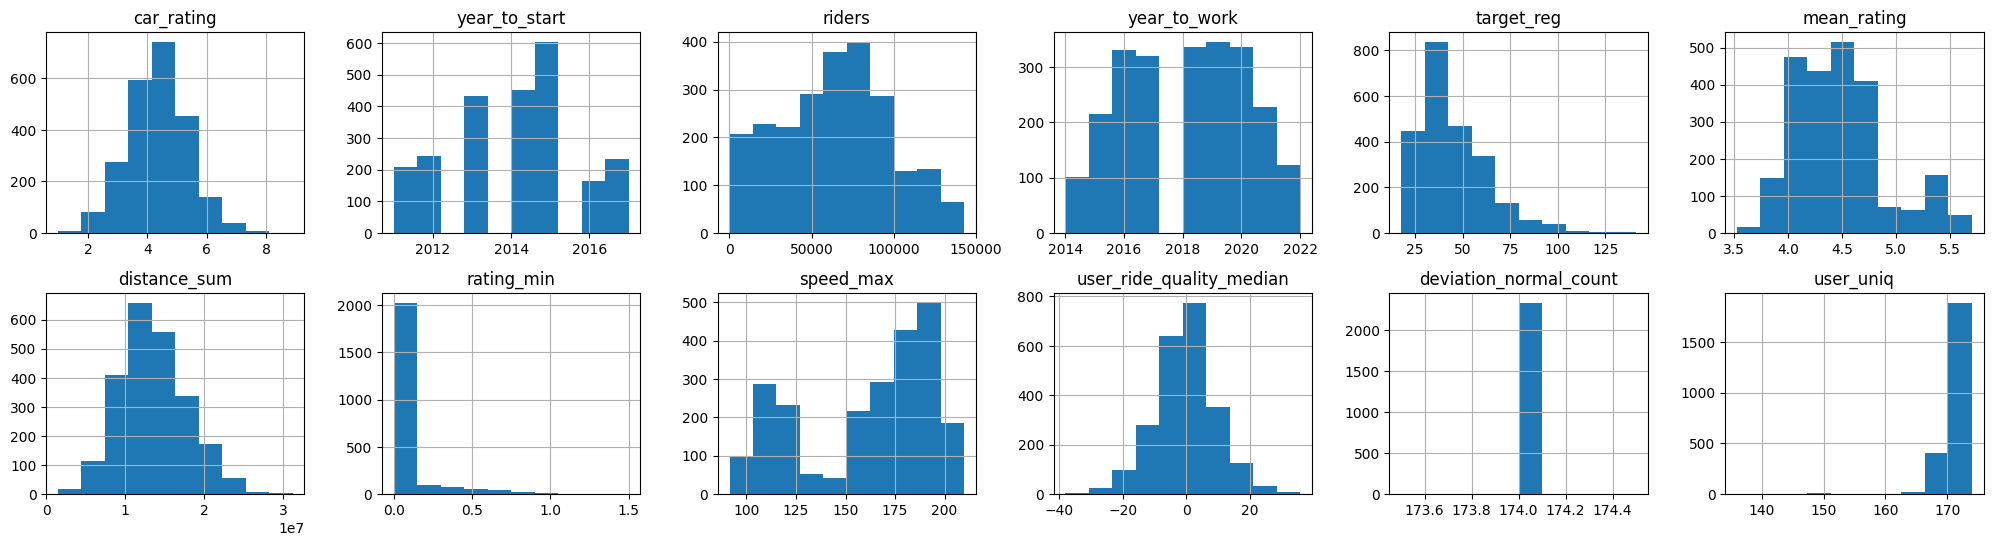

In [2]:
path = "../data/quickstart_train.csv"
train = pd.read_csv(path)

print("train", train.shape)
train.hist(figsize=(25, 6), layout=(-1, 6))
train.sample(3)

# <center> Группируем признаки и отбираем категориальные

In [3]:
cat_features = ["model", "car_type", "fuel_type"]  # Выделяем категориальные признаки
targets = ["target_class", "target_reg"]
features2drop = ["car_id"]  # эти фичи будут удалены

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print("cat_features", cat_features)
print("num_features", len(num_features))
print("targets", targets)

for c in cat_features:  # Избавлеямся от NaN'ов
    train[c] = train[c].astype(str)

cat_features ['model', 'car_type', 'fuel_type']
num_features 11
targets ['target_class', 'target_reg']


# <center> **`CatBoost`** **`Classifier`** и его параметры

<p id="c1"></p>    
<div class="alert alert-info">

Задача - использовать  **`CatBoost`** для классификации поломок. Посмотрим, сможет ли алгоритм справиться с поставленной задачей.

Перед использованием рассмотрим параметры модели ([подробнее читай здесь](https://catboost.ai/en/docs/references/training-parameters/common)): 

In [4]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [5]:
# Какие параметры есть в Catboost? посмотрим через shift + Tab
CatBoostClassifier()

<div class="alert alert-info">
    
**Базовые параметры**
    
* `iterations` (синонимы `num_boost_round`, `n_estimators`, `num_trees`) - максимальное количество деревьев, используемых в модели (по умолчанию **`1000`**). <br>
    Значение может быть ниже заданного, если используются другие параметры, накладывающие ограничение на количество деревьев;
* `learning_rate` или `eta` – скорость обучения, которая определяет, насколько быстро или медленно модель будет учиться. Значение по умолчанию обычно равно **`0.03`**.
* `depth (max_depth)` - глубина дерева (по умолчанию 6, максимальное значение - 16); 
* `cat_features` - список наименований категориальных признаков; 

**Режим обучения**

* `loss_function` или `objective`- функция потерь, которую надо минимизировать при обучении. Есть показатели для регрессии (среднеквадратичная ошибка), есть для классификации (`logloss`).
* `eval_metric` - валидационная метрика, используемая для обнаружения переобучения и ранней остановки;
* `custom_metric` - отслеживаемые метрики. Лучшие метрики в процессе обучения можно вернуть методом `get_best_score`;
* `early_stopping_rounds` - определяет число итераций до остановки, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной;
* `use_best_model` - если **`True`**, в результате обучения с ранней остановкой будет возвращаться модель, полученная на итерации (количеством деревьев) с лучшей метрикой на валидационной выборке;

<div class="alert alert-info">
    
**Регуляризация модели, ускоряющие и обобщающие модель**
    
* `l2_leaf_reg` (или `reg_lambda`) – коэффициент при члене регуляризации **`L2`** функции потерь. Значение по умолчанию – **`3.0`**.
* `min_data_in_leaf (min_child_samples)` -  минимальное количество обучающих сэмплов в листе. 
* `max_leaves (num_leaves)` - максимальное количество листьев в дереве. 
* `subsample` - часть исходной выборки, отбираемая для обучения каждого дерева;
* `colsample_bylevel` - доля признаков, используемая для отбора на каждом сплите;
* `max_bin` - максимальное число бинов, на которые разбиваются признаки

**Полезно использовать**    
    
* `random_seed` или `random_state` – инициализирующее значение для используемого генератора случайных чисел, чтобы обеспечить воспроизводимость эксперимента;
* `task_type` - используемое для вычислений устройство (**`CPU`**, **`GPU`**);
* `thread_count` - число используемых для обучения потоков (по умолчанию = **`-1`**, что означает - все ядра процессора);
* `verbose` - объем выводимой информации (**`False`** - подавляем сообщения).

<div class="alert alert-info">

**Балансировка классов**

* `class_weights` - веса классов в моделях классификации. Используется для устранения дисбаланса (например, вес `positive`= `количество_negative`/`количество_positive`);
* `classes_count` - количество классов для многоклассовой классификации;
* `auto_class_weights` - устраняет дисбаланс автоматически (значения - **`Balanced`**, **`SqrtBalanced`**);
* `scale_pos_weight` - задает вес для положительного класса; Среди параметров `scale_pos_weight`, `auto_class_weights`, `class_weights` одновременно используется только один.

## <center> Для начала обучим **`CatBoost`** с параметрами по умолчанию:

In [6]:
from sklearn.model_selection import train_test_split

X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.109335
0:	learn: 1.8108068	test: 1.8310378	best: 1.8310378 (0)	total: 52.8ms	remaining: 52.8s
200:	learn: 0.2789378	test: 0.5441162	best: 0.5374049 (156)	total: 1.53s	remaining: 6.09s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5374048663
bestIteration = 156

Shrink model to first 157 iterations.


<div class="alert alert-info">
    
Видим, что **`CatBoost`** сам установил параметр `learning_rate = 0.109335` <br>
Теперь давайте поменяем количество деревьев.

In [52]:
clf = CatBoostClassifier(iterations=100,
                         thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=10,
    use_best_model=True,
    early_stopping_rounds=50,
)

Learning rate set to 0.26253
0:	learn: 1.4248763	test: 1.4207873	best: 1.4207873 (0)	total: 4.37ms	remaining: 433ms
10:	learn: 0.5816760	test: 0.6235356	best: 0.6235356 (10)	total: 50.5ms	remaining: 408ms
20:	learn: 0.4815769	test: 0.5504441	best: 0.5504441 (20)	total: 94.5ms	remaining: 356ms
30:	learn: 0.4339785	test: 0.5356849	best: 0.5338202 (29)	total: 144ms	remaining: 321ms
40:	learn: 0.3799048	test: 0.5187874	best: 0.5187874 (40)	total: 193ms	remaining: 278ms
50:	learn: 0.3423726	test: 0.5096558	best: 0.5087483 (48)	total: 242ms	remaining: 233ms
60:	learn: 0.3165420	test: 0.5101417	best: 0.5087483 (48)	total: 289ms	remaining: 184ms
70:	learn: 0.2879564	test: 0.5102331	best: 0.5087483 (48)	total: 334ms	remaining: 136ms
80:	learn: 0.2643725	test: 0.5101204	best: 0.5085682 (76)	total: 380ms	remaining: 89.2ms
90:	learn: 0.2439870	test: 0.5100987	best: 0.5085682 (76)	total: 426ms	remaining: 42.1ms
99:	learn: 0.2244591	test: 0.5118741	best: 0.5085682 (76)	total: 466ms	remaining: 0us

b

<div class="alert alert-info">
    
Число деревьев уменьшили вдвое и `learning_rate` тоже пересчитался - стал больше: `0.14248`. Он также зависит не только от числа деревьев, но и пересчитывается под размеры датасета - это одна из крутых фишек CatBoost, и поэтому он может выдавать хорошую точность из коробки. Чтобы посмотреть другие гиперпараметры модели и как они меняются, можно вызвать метод: `clf.get_all_params()`

In [9]:
# Посмотрим на feature importance с помощью встроенного метода
# Не забываем про параметр prettified, чтобы список вывелся в виде красивой таблицы
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,speed_max,36.712356
1,mean_rating,33.260522
2,rating_min,12.774934
3,model,4.438743
4,user_uniq,2.990045
5,car_type,2.745549
6,riders,1.738469
7,user_ride_quality_median,1.697093
8,car_rating,1.332812
9,distance_sum,1.162986


<p id='c2'></p>

# <center> Настраиваем обучение по фолдам

In [10]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import KFold  # k-фолдная валидация

In [18]:
n_splits = 3  # Число фолдов. Оптимально 3, 5 или 10
clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# параметры валидации, обучение будет идти на n_splits фолдах
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_class"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Специальный класс для ускорения обучения 
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    clf = CatBoostClassifier(
        depth=4,
        iterations=3500,
        learning_rate=0.06,
        loss_function="MultiClass",  # MultiLogloss
        # eval_metric = 'Precision',  F1:macro / AUC:hints=skip_train~false
        custom_metric=["Recall"],  # 'AUC / Accuracy,
        
        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_features,
        # ignored_features = ignored_features,
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры скорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=7575,
        auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "Recall" in k], dtype="float16"))
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print("mean Recall score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

0:	learn: 2.1956073	test: 2.1958090	best: 2.1958090 (0)	total: 939us	remaining: 3.29s
500:	learn: 0.4702692	test: 0.5569354	best: 0.5569354 (500)	total: 525ms	remaining: 3.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5096496804
bestIteration = 916

Shrink model to first 917 iterations.
0:	learn: 2.1951404	test: 2.1964014	best: 2.1964014 (0)	total: 887us	remaining: 3.11s
500:	learn: 0.4909194	test: 0.5563577	best: 0.5562080 (497)	total: 516ms	remaining: 3.09s
1000:	learn: 0.3967000	test: 0.5050570	best: 0.5050184 (997)	total: 1.03s	remaining: 2.58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4961039188
bestIteration = 1241

Shrink model to first 1242 iterations.
0:	learn: 2.1956876	test: 2.1960187	best: 2.1960187 (0)	total: 869us	remaining: 3.04s
500:	learn: 0.4706323	test: 0.5434797	best: 0.5434797 (500)	total: 505ms	remaining: 3.02s
1000:	learn: 0.3921691	test: 0.5102073	best: 0.5102073 (1000)	total: 1.01s	remaining: 2.53s
Stopped by 

In [ ]:
# clf.best_score_['validation']

<div class="alert alert-info">
    
* `cat_features` — массив с категориальными столбцами.
* `ignored_features` — указывает на признаки, которые нужно игнорировать в процессе обучения.
* `task_type` – используете вы **`CPU`** или **`GPU`**. По умолчанию стоит **`CPU`**.
* `devices` — идентификаторы устройств **`GPU`**, которые будут использоваться для обучения.

In [ ]:
# 0.843 - > 0.90

<p id="c3"></p>    
    
# <center>🤹‍📈 **`Best practices`** по настройке **`Catboost`**

<div class="alert alert-info">
    
- 🍏 Категориальные признаки помещать в `cat_features`. Сами не кодируем. 
-  ⚠️ Фиксировать `random_seed` модели и разбиения. (В идеале, порядок фичей тоже)
- 🍏 Помещать данные в `Pool` для ускорения. (Квантилизация заранее)
- 🎓 Иметь `eval_set`, чтобы выставить `early_stopping_rounds`
- 🍏 Использовать регуляризационные параметы `l2_leaf_reg`, `colsample_bylevel`, `subsample` и другие
- 🎓 Ставить `max_depth` как можно меньше при том же уровне точности
- 🍏 `iterations` должен быть с запасом для срабатывания `early_stopping_rounds`
- 🎓 `learning_rate` подбирается по метрике.
- 🍏 Метрика - та, что заявлена в чемпионате. (**Recall**, **MAE**, **Корреляция** ...)
- ⚠️ Оцениваем модель по **`score = mean(metrics) - std(metrics)`**!
- 📈 Иногда записываем значения метрики локально и их значение на лидерборде.  

# <center> Анализ и интерпретация модели
    
<div class="alert alert-info">
    
Полезный кусочек кода, который полезно использовать для визуализации.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
    
    print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    train[filtered_features].drop(targets, axis=1, errors="ignore"),
    best_model = clfs,
    height = 0.20,
    top_n=13,
)

## <center>**`Feature Importance`** с помощью **Shap**.</center>

[Ссылка на документацию Shap](https://shap.readthedocs.io/en/latest/)

In [ ]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python shap -q

In [ ]:
import shap

shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(clfs[-1])

train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)

shap.summary_plot(shap_values, X_train, max_display=25)

# <center> Теперь произведем инференс модели

In [ ]:
# dir(clf)

In [ ]:
path = "../data/quickstart_test.csv"
sub = pd.read_csv(path)

# массив для записи финального прогноза size*n_class
y_pred = np.zeros((sub.shape[0], train[targets].nunique()[0]))

# Пробегаемся по моделям каждого фолда и дергаем прогноз 
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(sub[filtered_features])

f = lambda x: clf.classes_[x]
sub["target_class"] = list(map(f, y_pred.argmax(axis=1)))

sub[["car_id", "target_class"]].to_csv("../subs/catboost_kfold.csv", index=False)
sub[["car_id", "target_class"]].head()

# <center>🔋 "Батарейки в комплекте!" </center>

<div class="alert alert-info">

Ещё одной важной особенностью **`CatBoost`** является большой набор полезных встроенных функций (батареек): всё что нужно внутри одного фреймворка:

* `Recursive Feature Selection` (рассматривался в ноутбуке по `Feature Selection`)
* `Object Selection` - отбор объектов для обучения. Удаляются "вредные".
* Подбор оптимальных гиперпараметров (`Grid search`)
* [Кросс-валидация](https://github.com/catboost/tutorials/tree/master/cross_validation)
* Обработка текстов и эмбеддингов

Посмотрим на некоторые из этих функций.

## <center> **`Object Importance`** или удаляем вредные примеры </center>

<div class="alert alert-info">
    
`**Object importance**` - позволяет оценить влияние каждого элемента обучающей выборки на значение целевой метрики (`eval_metric`). То есть, с помощью этой функции можно найти и избавиться от выбросов, шума и прочего мусора в тренировочном датасете.

На данный момент, расчет **object importance** доступен только для некоторых лосс-функций: 

`Logloss`, `CrossEntropy`, `RMSE`, `MAE`, `Quantile`, `Expectile`, `LogLinQuantile`, `MAPE`, `Poisson`

В списке нет `MultiLogloss`, поэтому для задачи мультиклассификации нельзя его рассчитать. Рассмотрим на примере регрессии.


In [ ]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Обучим модель регрессии
model = CatBoostRegressor(
    random_seed=42, thread_count=-1, cat_features=cat_features, eval_metric="RMSE"
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

<div class="alert alert-info">
    
Рассмотрим основные параметры метода `get_object_importance`: <br>
```python
get_object_importance(pool,
                      train_pool,
                      top_size=-1, # число возвращаемых наиболее важных объектов из трэйн датасета (-1 без ограничений)
                      type='Average', # тип вычисления `Average` или `PerObject` - второй тип дольше
                      importance_values_sign='All' # `Positive`, `Negative`, `All` - зависит от оптимизируемой метрики
                      update_method='SinglePoint', # `SinglePoint` — быстрейший, `TopKLeaves`, `AllPoints` — Самый медленный и самый точный метод.
                      )
```

In [ ]:
# метод возвращает отсортированные списки индексов и скоров
idxs, scores = model.get_object_importance(
    test_pool, train_pool, importance_values_sign="Positive", thread_count=-1
)
len(idxs)

In [ ]:
# Нашлось 1070 объектов, которые увеличивают нашу RMSE, посмотрим на топ-20
scores[:20]

In [ ]:
# Попробуем отбросить топ-100 найденных и посмотрим как изменится точность
train_pool = Pool(
    X_train.reset_index(drop=True).drop(idxs[:100]),
    y_train.reset_index(drop=True).drop(idxs[:100]),
    cat_features=cat_features,
)

model = CatBoostRegressor(
    random_seed=42, thread_count=-1, cat_features=cat_features, eval_metric="RMSE"
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

<div class="alert alert-info">
    
`RMSE` уменьшилась на `~ 0.5`. Можете ещё поэкспериментировать с другими параметрами и отбрасыванием большего количества объектов.

## <center> Подбор оптимальных гиперпараметров. </center>

<div class="alert alert-info">

В `CatBoost` реализовано 2 метода подбора гиперпараметров модели: `grid_search` и `randomized_search`. Как заявляют авторы фреймворка, методы оптимизированы и справляются с задачей быстрее, чем аналогичные из `sklearn`. [Grid search](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search) просто перебирает параметры по заданной сетке, [randomized search](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_randomized_search) берет рандомные сэмплы из заданного распределения.

Посмотрим пример с `randomized search`. В последующих модулях вы узнаете про более быстрые и умные оптимизаторы гиперпараметров, но начать можно с этих. 

In [ ]:
from scipy import stats

model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_features,
    eval_metric="RMSE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_train, y_train)
model.best_score_

In [ ]:
# Лучшие параметры модели из перебора
randomized_search_result["params"]

# <center> 🎓Какие еще полезные параметры есть в **`Catboost`**?

<div class="alert alert-info">

**Многие знают, что такое `random_seed`, `learning_rate`, `iterations`, поэтому обсудим другие:**
* `boosting_type` – тип бустинга, который используется при обучении
  * значение `Plain` дает качество хуже, но работает быстрее
  * есть другой более затратный тип — `Ordered`, но дает лучшее качество (только для небольших датасетов).
* `bootstrap_type` –  определяет метод сэмплинга весов объектов. Когда мы строим дерево, построение идет не по всем объектам обучающей выборки, а по нескольким объектам. Это может быть Байес, Бернулли, многомерная случайная величина или Пуассон.
* `subsample` – вероятность, по которой будет выбираться каждый объект для построения дерева. Параметры `bootstrap_type` и `subsample` идут в связке.
* `one_hot_max_size` – это горячее кодирование определенных переменных выборки (конвертируем каждое категориальное значение в новый категориальный столбец и присваиваем этим столбцам двоичное значение 1 или 0). 
* `RSM` - аналогичен `subsample`, только используется **для фичей, а не объектов**.
* `leaf_estimation_iterations` – количество итераций подсчета значений в листьях.
* `max_ctr_complexity` – длина перебора комбинаций фичей из данной выборки. Разделение ветвей не только по отдельным признакам, **но и по их комбинациям - одна из ключевых особенностей CatBoost.**

In [ ]:
from catboost import CatBoost

fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type="Plain",
    bootstrap_type="Bernoulli",
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    # cat_features = cat_features,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    early_stopping_rounds=10,
)

fast_model.fit(
    train_dataset,
    eval_set=eval_dataset,
    verbose=100,
    # plot=True
);

# <center> Какие параметры использовались в модели?

In [ ]:
fs2noshow = [
  "boosting_type","boosting_type","max_ctr_complexity","leaf_estimation_iterations", "rsm","one_hot_max_size",
    "subsample", "depth","task_type","eval_metric","iterations", "loss_function","min_data_in_leaf",
    "learning_rate", "auto_class_weights","classes_count", "random_seed","l2_leaf_reg",
]

for key, value in fast_model.get_all_params().items():
    if key not in fs2noshow:
        print("{}, {}".format(key, value))

# <center> Давайте рассмотрим параметры в **`CatBoost`**, которые еще не обсуждали:

<div class="alert alert-info">
    
**Режимы построения дерева (политика роста)**
    
`grow_policy` – определяет, как будет применяться жадный алгоритм поиска. Может стоять в значении **`SymmetricTree`**, **`Depthwise`** или **`Lossguide`**. По умолчанию **`SymmetricTree`**.
  * **`SymmetricTree`** - дерево строится уровень за уровнем, пока не достигнет необходимой глубины. На каждом шаге листья с предыдущего дерева разделяются с тем же условием.
  * **`Depthwise`** дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь.
  * **`Lossguide`** дерево строится по листьям до тех пор, пока не будет достигнуто заданное количество листьев. На каждом шаге разделяется нетерминальный лист с лучшим уменьшением потерь. lightGBM
    

**Напоминание:**

* `min_data_in_leaf` или `min_child_samples` – это минимальное количество обучающих сэмплов в листе. Этот параметр используется только с политиками роста **`Lossguide`** и **`Depthwise`**.
* `max_leaves` или `num_leaves` – этот параметр используется только с политикой **`Lossguide`** и определяет количество листьев в дереве.

<div class="alert alert-info">

**Пропуски в численных фичах**
    
* `nan_mode` – метод работы с пропущенными значениями.
  * Параметры **`Forbidden`**, **`Min`** и **`Max`**. 
  * При использовании **`Forbidden`** наличие пропущенных значений вызовет ошибку.
  * При использовании параметра **`Max`**, пропущенные значения будут приняты за **максимальные** значения для данного признака. 
  * При использовании параметра **`Min`**, пропущенные значения будут приняты за **минимальные** значения для данного признака.
    

### ⛄️ Параметров много. Про некоторые из них в другой раз 

<div class="alert alert-info">
    
    
* `score_function` – тип оценки, используемой для выбора следующего разбиения при построении дерева. 
  * **`Cosine`** используется по умолчанию.
  * Другие доступные варианты **`L2`**, **`NewtonL2`** и **`NewtonCosine`**.
    
* `leaf_estimation_backtracking` – тип бэктрекинга, использующийся при градиентном спуске. По умолчанию используется **`AnyImprovement`**. 
  * **`AnyImprovement`** уменьшает шаг спуска до того, как значение функции потерь будет меньшим, чем оно было на последней итерации.
  * **`Armijo`** уменьшает шаг спуска до тех пор, пока не будет выполнено условие Вольфе.
* `text_features` — используется для объявления текстовых столбцов в задачах классификации.

# <center> Сохраняем и подгружаем модель

<div class="alert alert-info">
    
Сохранить обученную модель **`CatBoost`** можно в нескольких форматах - `json`, `cpp`, `onnx`. <br>
Однако, в `CatBoost` есть собственный формат для сохранения моделей `cbm` (**CatBoost binary format**), предпочтительно сохранять модели именно в этом формате.

In [ ]:
params = {
    "iterations": 100,
    "learning_rate": 0.001,
    "depth": 7,
    "bootstrap_type": "Bernoulli",
    "subsample": 0.9,
    "random_seed": 7575,
}


clf = CatBoostClassifier(**params)

clf = clf.fit(train_dataset, eval_set=eval_dataset, verbose=False)

print(clf.get_params())

In [ ]:
model.save_model("../others/catboost_model.cbm", format="cbm")  # format по умолчанию cbm поэтому можно явно не указывать

Теперь загрузим нашу модель и проверим параметры:

In [ ]:
new_clf = CatBoostClassifier()
new_clf.load_model("../others/catboost_model.cbm")

In [ ]:
print(new_clf.get_params())

# <center> Другие модели и режимы

<div class="alert alert-info">

* В рамках этого ноутбука мы рассмотрели только модель для классификации. Позже коснемся регрессии.   
* Катбуст может решать задачу мульти-классификация или даже мульти-лейбл классификации. (Меняется лосс-функция)
* Но библиотека также содержит модель для решения задач ранжирования [**CatBoostRanker**](https://catboost.ai/en/docs/concepts/python-reference_catboostranker). <br>
* Пример решения [задачи мэтчинга с помощью CatBoostRanker на VTB DataFusionContest2022](https://github.com/Ivanich-spb/VTB_DataFusion_Contest_2022) от авторов курса.

# 🧸 Выводы и заключения

- 🧩 Катбуст - мощный и многофункциональный фреймворк
- 🧩 Много параметров и тонкостей
- 🧩 Отличный вариант для старта
- 🧩 Полезно понимать принцип работы градиентных бустингов

# <center> Полезные источники

    
* [Очень подробная статья про работу Catboost, (если не знаете, как он работает)](https://habr.com/ru/company/ods/blog/645887/)
* [Работа с параметрами для категориальных фичей](https://towardsdatascience.com/categorical-features-parameters-in-catboost-4ebd1326bee5) 
* [Трилогия Яндекса про катбуст. Часть 1](https://habr.com/ru/company/ods/blog/594077/) | [Часть 2](https://habr.com/ru/company/ods/blog/599827/) | [Часть 3](https://habr.com/ru/company/ods/blog/648939/)